In [42]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("../../../src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

import multiprocessing

#### Input Voltage

Number of Steps: 100000


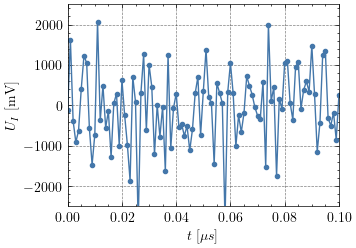

In [56]:
# Define Time Scale
step_size   = 1e-9
max_time    = 1e-4
time_steps  = np.arange(0,max_time,step_size)
N_steps     = len(time_steps)

print(f"Number of Steps: {N_steps}")

input_volt = np.random.normal(0.0,1,N_steps)

# Voltage Array
voltages        = np.zeros((N_steps, 9))
voltages        = np.zeros((N_steps, 9))
voltages[:,0]   = input_volt

# Plot
with plt.style.context(["science","bright","grid"]):
    
    plt.plot(time_steps*10**6, input_volt*1000, '.-')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$U_I$ [mV]")
    plt.xlim(0,0.1)
    plt.ylim(-2500,2500)
    plt.show()

#### Init Network

In [44]:
# Network Style
network_topology    = "cubic"
N_d                 = 7 
topology_parameter  = {
    "Nx"    : N_d,
    "Ny"    : N_d,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[0,3,0],[6,0,0],[0,6,0],[6,3,0],[3,6,0],[6,6,0]]
}

# Topology Class
np_network_sim = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)

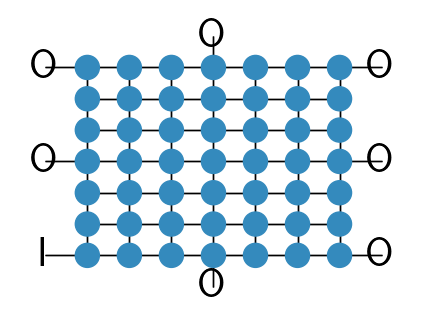

In [45]:
fig, ax = nanonets_utils.display_network(np_network_sim, provide_electrode_labels=['I','O','O','O','O','O','O','O'],
                                        font_size=30, save_to_path='plots/network.pdf', width_scale=1.5, height_scale=1.5)

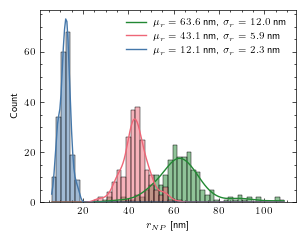

In [46]:
df      = pd.read_csv("np_sizes_exp.CSV", sep=';', names=['small','medium','large'])
df      = df/1000
r_means = df.mean().values
r_stds  = df.std().values

legend_labels = [f"$\mu_r = {round(r_means[i],1)}$"+" nm, "+f"$\sigma_r = {round(r_stds[i],1)}$"+" nm" for i in range(3)]
legend_labels.reverse()

with plt.style.context(["science","nature","bright"]):

    fig, ax = plt.subplots()
    ax      = sns.histplot(data=df, bins=50, ax=ax, kde=True)
    ax.legend(legend_labels)
    ax.set_xlabel("$r_{NP}$ [nm]")
    fig.savefig("plots/np_radius_dist.pdf", bbox_inches='tight')

#### Load Data

In [51]:
def load_data(folder):

    mc_mean = []
    mc_stds = []

    for rem_d in np.arange(0,18,1):

        values = []
        
        for i in range(10):

            df  = pd.read_csv(f"{folder}mc_test_results_{rem_d}_{i}.csv", index_col=0)

            values.append(df.corr().loc['y_pred','y_test'])

        mc_mean.append(np.mean(values))
        mc_stds.append(np.std(values)/np.sqrt(10))
    
    return mc_mean, mc_stds

# ADD Equilibrium Time and skip first t in output

In [52]:
mc_mean, mc_stds        = load_data("data/lattice_without_disorder/")
mc_mean_C1, mc_stds_C1  = load_data("data/lattice_C_disorder/c1/")
mc_mean_C2, mc_stds_C2  = load_data("data/lattice_C_disorder/c2/")
mc_mean_C3, mc_stds_C3  = load_data("data/lattice_C_disorder/c3/")

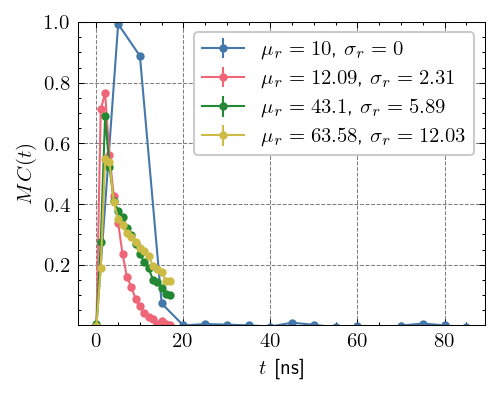

In [58]:
xvals = np.arange(0,18,1)*step_size*10**9

with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=150)
    ax  = fig.add_subplot()
    ax.errorbar(xvals*5, mc_mean, mc_stds, marker='.', label='$\mu_r = 10$, $\sigma_r = 0$')
    ax.errorbar(xvals, mc_mean_C1, mc_stds_C1, marker='.', label=f'$\mu_r = {np.round(r_means[0],2)}$, \t$\sigma_r = {np.round(r_stds[0],2)}$')
    ax.errorbar(xvals, mc_mean_C2, mc_stds_C2, marker='.', label=f'$\mu_r = {np.round(r_means[1],2)}$, \t$\sigma_r = {np.round(r_stds[1],2)}$')
    ax.errorbar(xvals, mc_mean_C3, mc_stds_C3, marker='.', label=f'$\mu_r = {np.round(r_means[2],2)}$, \t$\sigma_r = {np.round(r_stds[2],2)}$')
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$MC(t)$")
    ax.legend()
    ax.set_ylim(0.001,1)

#### Output Matrix

In [36]:
W_outs  = pd.DataFrame()

for rem_d in range(0,21):
    
    W_out           = np.array([np.loadtxt(f"data/lattice_without_disorder/Wout_{rem_d}_{i}.csv") for i in range(10)]).flatten()
    # W_out           = 2*(W_out - np.min(W_out))/(np.max(W_out) - np.min(W_out)) - 1
    # W_out           = (W_out - np.mean(W_out))/np.std(W_out)
    W_out           = pd.DataFrame(W_out, columns=['value'])
    W_out['rd']     = rem_d
    W_outs          = pd.concat([W_outs, W_out])

W_outs

,value,rd
0,0.000002,0
1,-0.000007,0
2,0.000021,0
3,0.000004,0
4,0.000008,0
...,...,...
65,0.000016,20
66,-0.000013,20
67,-0.000003,20
68,0.000009,20


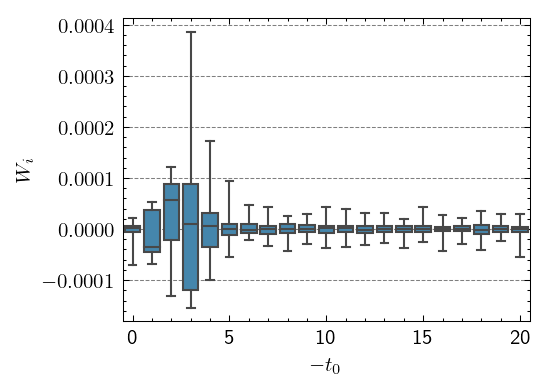

In [38]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=150)
    ax  = fig.add_subplot()
    # ax  = sns.stripplot(data=W_outs, x='rd', y='value', color=nanonets_utils.blue_color)
    ax  = sns.boxplot(data=W_outs, x='rd', y='value', color=nanonets_utils.blue_color, whis=(0,100))
    ax.set_xlabel("$-t_0$")
    ax.set_ylabel("$W_i$")
    ax.set_xticks([0,5,10,15,20])

In [39]:
W_outs  = pd.DataFrame()

for rem_d in range(0,21):
    
    W_out           = np.array([np.loadtxt(f"data/lattice_C_disorder/c3/Wout_{rem_d}_{i}.csv") for i in range(10)]).flatten()
    # W_out           = 2*(W_out - np.min(W_out))/(np.max(W_out) - np.min(W_out)) - 1
    # W_out           = (W_out - np.mean(W_out))/np.std(W_out)
    W_out           = pd.DataFrame(W_out, columns=['value'])
    W_out['rd']     = rem_d
    W_outs          = pd.concat([W_outs, W_out])

W_outs

,value,rd
0,2.171338e-06,0
1,1.640902e-08,0
2,-1.130678e-05,0
3,3.241138e-06,0
4,-1.541940e-05,0
...,...,...
65,6.510569e-06,20
66,-4.365671e-06,20
67,3.409484e-05,20
68,2.917580e-06,20


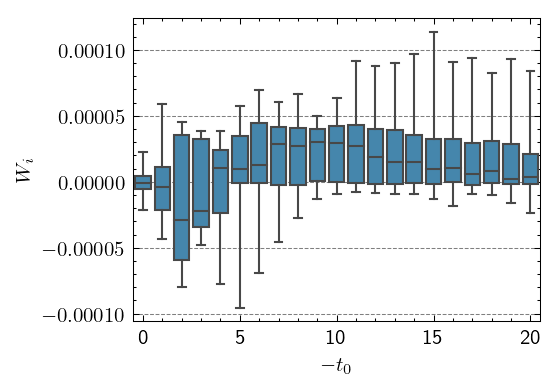

In [40]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=150)
    ax  = fig.add_subplot()
    # ax  = sns.stripplot(data=W_outs, x='rd', y='value', color=nanonets_utils.blue_color)
    ax  = sns.boxplot(data=W_outs, x='rd', y='value', color=nanonets_utils.blue_color, whis=(0,100))
    ax.set_xlabel("$-t_0$")
    ax.set_ylabel("$W_i$")
    ax.set_xticks([0,5,10,15,20])